### IMPORTANT TO DOs - remove from the submission to AWS

<p>
__!!!_ADD A SIDEBAR TO THE NOTEBOOK_!!!__
<br>
https://github.com/ipython-contrib/jupyter_contrib_nbextensions
<p>
#### Refactor the code. Create functions for plotting, dummy variables creation, crosstabulation, etc.



### Reduce maintenance cost through predictive techniques
___Valentin Todorov (January 2018)___

#### Background
Company (3D Technologies) has a fleet of devices transmitting daily aggregated telemetry
attributes.

Predictive maintenance techniques are designed to help determine the condition of in-service
equipment in order to predict when maintenance should be performed. This approach
promises cost savings over routine or time-based preventive maintenance, because tasks are
performed only when warranted.

#### Goal:
You are tasked with building a predictive model using machine learning to predict the
probability of a device failure. When building this model, be sure to minimize false positives and
false negatives. The column you are trying to predict is called failure with binary value 0 for
non-failure and 1 for failure.

#### Data
Download link: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv

#### Plan for development
1. Read the data
2. Data exploration
    * Calculate the distribution of total fail/not fail cases
    * Distribution of fail/not-fail cases by year
    * Distribution of fail/not-fail cases by month
    * Are there any devices that have higher failure rates than others
    * When a device fails, does it disappear from the data, or does it show up again
    * Are there particular days of the week when a higher percent of devices fail?
3. Understand the important variables for splitting the dataset
    * Do a pre-modeling analysis using decision trees
    * Use decision trees to understand which are the important drivers for the outcome
4. Derive new features
    * Determine which features are categorical, and if needed create dummies
    * Since the data for some of the features is very sparse, create dummies which are 1, if data is available and 0 otherwise
    * Use decision trees to decide how to split by categories of attributes
    * Should I do PCA? (likely no..)
5. Sampling of the data (70/30)
    * Create random samples from the data - 70% for training and 30% for validation
    * If the failures are too few compared to the non-failures, I will need to oversample the failures (and add a weight), or simply undersample the non-failures
    * Dealing with imbalanced datasets (https://datascience.stackexchange.com/questions/9488/xgboost-give-more-importance-to-recent-samples)
6. Do we need separate models for different groups of devices?
    * Use decision trees to figure this out
        * Run decision trees on all devices
        * Run decision trees by types of devices, determined by the first letter - S, W, or Z
7. Variables reduction
    * Use decision trees
    * Use p-values
    * LASSO
    * Random forest's variable importance
    * Stepwise logistic regression
    * Compare the suggested features from each method
8. Decide on a methodology for the model estimation
    * Random forest
    * Random forest with XG boosting
    * Random forest with ADA
    * SVM
    * Penalized-SVM
    * Neural network
    * Logistic regression
9. Validate the results
10. Accuracy measures
    * Calculate c-statistic and ROC
    * Plot the performance for multiple modles using the area under the curve (AUC) graph
    * Create a deciles table with lift, and graph it
    * Sensitivity/Recall
    * Specificity
11. Create a confusion matrix - reduce false positives and false negatives
12. Does the methodology we use allow us to understand what drives the outcome? If it doesn't, do we need another methodology that can help with that?


#### Environment
The model was developed in Python 3.5

#### Setup
Setup the environment and import needed packages

In [1]:
import pandas as pd
import numpy as np
from decimal import *
import graphviz                             # This module is needed for the visualization of the decision tree, but I can't import it in Python 3.6
import matplotlib.pyplot as plt
import math

import xgboost as xgb
from sklearn import datasets, svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

%matplotlib inline


/Users/valentin/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Define functions I'll be using throughout the analysis
This section defines functions I'll use in the analysis, and the evaluation of results.

In [2]:
# This defines the path to the data depending on the OS I use - Win or mac OS
# I've saved the dataset in my Google Drive, but depending on my location, I use different computers (Mac or Windows) and the paths to the folders are different
def selectOS(_os):
    if _os == "win":
        data_location = "C:/Users/bre49823/GoogleDrive/Data/aws/device_failure.csv"
    elif _os == "mac":
        data_location = "/Users/valentin/GoogleDrive/Data/aws/device_failure.csv"
    return data_location

# Check for NA values in the data
def checkNaValues(df, columns_idx):
    features_na = []
    for i in range(0, len(columns_idx)):
        col = columns_idx[i]
        features_na.append(df[col].isnull().sum())
    return features_na

# Create new features that are the log of existing ones
def createLog(df, columns_list):
    for col in columns_list:
        column_log = col + "_log"    
        df[column_log] = df[col].apply(lambda x: 0 if x == 0 else math.log(x))
    return

# Derive dummy features - these features take the value 1 if the value in the original features is larger than 0, otherwise they take the value of 0
def createDummy(columns_list):
    column_dummy_idx = []
    for col in columns_list:
        column_dummy = col + "_dummy"
        device_data[column_dummy] = [1 if x > 0 else 0 for x in device_data[col]]
        column_dummy_idx.append(column_dummy)
    return column_dummy_idx
        
# Create a confusion matrix
def confusionMatrix(model, _x_validate, _y_validate):
    _confusion_matrix = confusion_matrix(_y_validate, model.predict(_x_validate)).ravel()
    return _confusion_matrix

# Function to print accuracy statistics for each model
def modelAccuracyStats(model, modeling_method, _x_train, _y_train, _x_validate, _y_validate):
    tn, fp, fn, tp = confusionMatrix(model, _x_validate, _y_validate)
    print ("Print stats for method: %s" % modeling_method)
    print ("\nThe number of False Negative in the validation set is %s " % str(fn))
    print ("The number of False Positive in the validation set is %s " % str(fp))
    print ("\nAccuracy on training set is {:.5f}".format(model.score(_x_train, _y_train)))
    print ("Recall (tp/(tp+fn)) of training set is {:.5f}".format(recall_score(_y_train, model.predict(_x_train))))
    print ("\nAccuracy on validation set is {:.5f}".format(model.score(_x_validate, _y_validate)))
    print ("Recall (tp/(tp+fn)) of validation set is {:.5f}".format(recall_score(_y_validate, model.predict(_x_validate))))
 

#### Read in the data and print out the header

In [3]:
# Read in the data and print out the header
device_data = pd.read_csv(selectOS("mac"))

# Check if the number of rows is as expected
print (len(device_data))
device_data.head(5)

124494


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Whenever I start working with a dataset I've never seen, I like to open it as a SQL table, or import it in Excel, and familiarize myself with it. If the file is small enough, and Excel can handle it, I'll import the whole file, otherwise, I take a random sample from it, small enough that can be easily processed within the available RAM and CPU.

Next, I usually create a pivot table in Excel and try to understand what features are available. Are there dates - if there are, what is the time range coverered? When we know the dates from the data, we can relate them to important Macroeconomic environments - major crises, stock market and crude oil price crashes, etc. Most of the real world industry processes are impacted by economic events. For example, if the data in the provided dataset spans back to 2007, it is very likely that we'll see structural shifts in some of the attributes during the period 2008 - 2009.

In [4]:
# Calculate the distribution of total fail/not fail cases
pct_fail_cases = sum(device_data["failure"]) / Decimal(len(device_data["failure"]))
print ("It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.")
print ("Only %0.7f of the cases are device failures " % pct_fail_cases)

It appears that the data is very imbalanced. The percent of fail cases is very low compared to the non-fail cases.
Only 0.0008514 of the cases are device failures 


Let's get a feeling of the mean values by category of the variable "failure"

In [5]:
device_data.groupby("failure").mean()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,,,,,,,,,
0,1.223827e+08,156.118725,9.945598,1.696048,14.221637,260174.451056,0.266682,0.266682,12.442462
1,1.271755e+08,4109.433962,3.905660,54.632075,15.462264,258303.481132,30.622642,30.622642,23.084906


In [6]:
device_data.groupby("failure").std()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,,,,,,,,,
0,7.046063e+07,2145.521965,185.824103,22.164316,15.943374,99147.774348,6.558071,6.558071,191.455015
1,6.940167e+07,12803.747239,31.557213,193.492528,15.547270,103349.308593,117.033610,117.033610,153.449984


From the analysis of observations when the values of each attribute is larger than 0, it looks like attributes 7 & 8 have the same number of cases when they are larger than 0. This requires a little more investigation. If both attributes have the same values, one of them will be dropped.

Next, I'll test if the values for attributes 7 & 8 are the same. I'll simply subtract attribute 7 from 8 and sum up the differences. If the sum is 0, then all the values for 7 & 8 are the same, and I'll drop column 8.

In [7]:
sum((device_data["attribute7"] - device_data["attribute8"]))

0

Based on the test, columns 7 & 8 are the same. Hence, I'll drop column 8.

In [8]:
drop_vars = ["attribute8"]
device_data = device_data.drop(drop_vars, axis = 1)

In [9]:
# Check if there are NA values in the data
# If the list with features is very long I wouldn't print the whole list with the results, but will only print those that with missing values
columns_list = list(device_data.columns)
features_na = checkNaValues(device_data, columns_list)
list(zip(columns_list, features_na))


[('date', 0),
 ('device', 0),
 ('failure', 0),
 ('attribute1', 0),
 ('attribute2', 0),
 ('attribute3', 0),
 ('attribute4', 0),
 ('attribute5', 0),
 ('attribute6', 0),
 ('attribute7', 0),
 ('attribute9', 0)]

There are no features with NULL or NaN values..

In [10]:
# Check for duplicate rows in the data
device_data[device_data.duplicated()]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9


There are no duplicate rows in the data.

#### Derive new features
1. Take the log of features with large values
<br>
Attribute1 & attribute6 have very large values compared with the rest of the features. So I'll take the logs.
<p>
2. Create dummies (0/1) from the existing features
<br>
If the value of an attribute is larger than 0, encode as 1, otherwise 0

In [11]:
# 1) Calculate the log of the attribute1 & attribute6
columns_list = ["attribute1", "attribute6"]
createLog(device_data, columns_list)

# 2) Create dummies from the attributes
columns_list = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute9"]

features_dummy = createDummy(columns_list)
list(zip(features_dummy, [device_data[s].value_counts() for s in features_dummy]))

[('attribute1_dummy', 1    124483
  0        11
  Name: attribute1_dummy, dtype: int64), ('attribute2_dummy', 0    118110
  1      6384
  Name: attribute2_dummy, dtype: int64), ('attribute3_dummy', 0    115359
  1      9135
  Name: attribute3_dummy, dtype: int64), ('attribute4_dummy', 0    115156
  1      9338
  Name: attribute4_dummy, dtype: int64), ('attribute5_dummy', 1    124494
  Name: attribute5_dummy, dtype: int64), ('attribute6_dummy', 1    124494
  Name: attribute6_dummy, dtype: int64), ('attribute7_dummy', 0    123036
  1      1458
  Name: attribute7_dummy, dtype: int64), ('attribute9_dummy', 0    97358
  1    27136
  Name: attribute9_dummy, dtype: int64)]

We'll also drop the dummies for columns 5 & 6 because they are always 1. Since they have the same value for every observation, they won't provide any useful information to the models.

In [12]:
drop_vars = ["attribute5_dummy", "attribute6_dummy"]
device_data = device_data.drop(drop_vars, axis = 1)

We need to dig a little deeper into the distributions of failure/non-failure and understand the following:
1. Distribution of failure/non-failure by year
2. Distribution of failure/non-failure by month
3. Distribution of failure/non-failure by device - are there specific devices that tend to fail more than others?

In [13]:
# Distribution of failure/non-failure by year
device_data["year"] = pd.to_datetime(device_data["date"]).dt.year
device_data["month"] = pd.to_datetime(device_data["date"]).dt.month
device_data["day_of_week"] = pd.to_datetime(device_data["date"]).dt.dayofweek
device_data["device_type"] = device_data.device.str[0]

# Create dummies for each of the three different devices in the data. Each starts with a different letter - S, W, or Z
device_data = pd.concat([device_data, pd.get_dummies(device_data["device_type"].str.lower(), prefix = "device_type")],
                        axis = 1, join_axes = [device_data.index])

# One-hot encode the failure variable
# failure_outcome = pd.get_dummies(device_data.failure)

# Print some summary stats
print(device_data.failure.value_counts())

print(pd.crosstab(device_data["year"],
                  columns = "count"))
pd.crosstab(device_data["month"],
            columns = "count") / len(device_data.month)

0    124388
1       106
Name: failure, dtype: int64
col_0   count
year         
2015   124494


col_0,count
month,
1,0.201070
2,0.156634
3,0.159309
4,0.096487
5,0.091008
6,0.084092
7,0.084590
8,0.067039
9,0.035905


It is evident that the data is only for 2015 and we have information for most of the months of 2015, except for December. However, note that 50% of the observations are from the period January - March.
<p>
Next, we'll look at the distribution of failure/non-failure by month

In [14]:
# Distribution of failure/non-failure by month
failure_month = pd.crosstab(index = device_data["failure"],
                            columns = device_data["month"],
                            margins = True)

failure_month.index = ["non_failure", "failure", "month_total"]
failure_month

month,1,2,3,4,5,6,7,8,9,10,11,All
non_failure,25008,19486,19824,12003,11309,10463,10515,8342,4470,2937,31,124388
failure,24,14,9,9,21,6,16,4,0,3,0,106
month_total,25032,19500,19833,12012,11330,10469,10531,8346,4470,2940,31,124494


In [15]:
failure_month_pct = failure_month / failure_month.loc["month_total"]
failure_month_pct

month,1,2,3,4,5,6,7,8,9,10,11,All
non_failure,0.999041,0.999282,0.999546,0.999251,0.998147,0.999427,0.998481,0.999521,1.0,0.99898,1.0,0.999149
failure,0.000959,0.000718,0.000454,0.000749,0.001853,0.000573,0.001519,0.000479,0.0,0.00102,0.0,0.000851
month_total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.0,1.000000


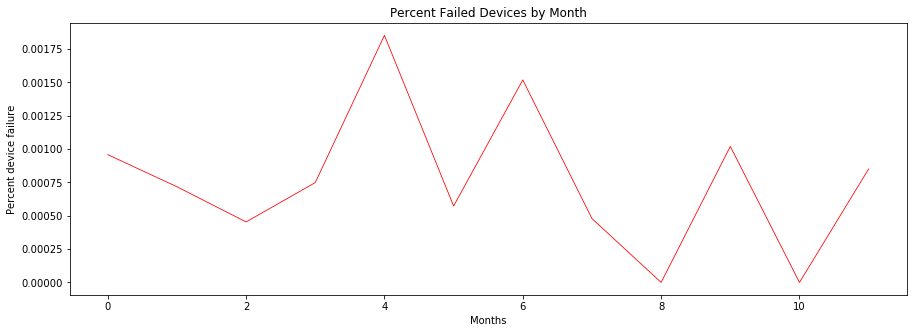

In [16]:
# Plot the % failures/non-failures by month
plt.figure(figsize = (15, 5))
plt.plot(list(failure_month_pct.loc["failure"]), linewidth = 0.8, color = "#ff0000")
plt.xlabel("Months")
plt.ylabel("Percent device failure")
plt.title("Percent Failed Devices by Month")

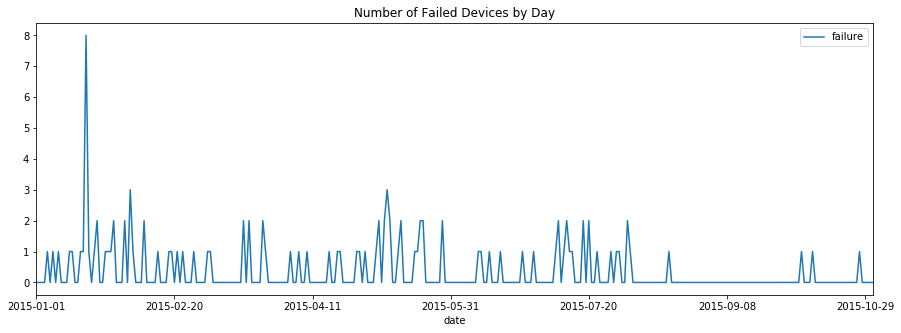

In [17]:
# Plot the % failures/non-failures by day
failure_day = pd.crosstab(index = device_data["date"],
                          columns = device_data["failure"],
                          margins = True)

failure_day.columns = ["non_failure", "failure", "total"]

failure_day[:-1].reset_index().plot(x = "date", y = "failure",
                                    figsize = (15, 5),
                                    title = "Number of Failed Devices by Day")

In [18]:
# Distribution of failure/non-failure by device type - are there specific devices that tend to fail more than others?
failure_device = pd.crosstab(index = device_data["device_type"],
                             columns = device_data["failure"],
                             margins = True)
failure_device.columns = ["non_failure", "failure", "total"]

print (failure_device["failure"] / failure_device["total"])
failure_device

device_type
S      0.000766
W      0.000971
Z      0.000834
All    0.000851
dtype: float64


,non_failure,failure,total
device_type,,,
S,54816,42,54858
W,43226,42,43268
Z,26346,22,26368
All,124388,106,124494


In [19]:
# Are there particular days of the week when a higher percent of devices fail?
failure_day_week = pd.crosstab(index = device_data["day_of_week"],
                               columns = device_data["failure"],
                               margins = True)
failure_day_week

failure,0,1,All
day_of_week,,,
0,17859,27,17886
1,17516,18,17534
2,17121,15,17136
3,18119,22,18141
4,18029,12,18041
5,17889,8,17897
6,17855,4,17859
All,124388,106,124494


In [20]:
# Prepare the data for the models
# Drop variables which will not be useful in the models
drop_from_analysis = ["date", "device", "year", "month", "device_type"]
analysis_set = device_data.drop(drop_from_analysis, axis = 1)

### Plan for 01/02/2018
1. Create a sample
    * Sample with replacement from the x_train sample
    * Use "class_weight = balanced" for the models that have that function
    * Use a sample weight - how am I going to deal with models that don't have the ability to incorporated a weight
2. Try scaling all the data before sampling and see if this improves the results
3. Create transformed variables
    * Square
    * Square root
4. Update the models
    * XGboost
        * Modify model parameters
        * How to control for the sample imbalance?
    * SVM
        * Need to rescale the full dataset and draw the training and validation samples from it
        * Figure out what all the parameters are

#### 5. Fix the ROC curve - it doesn't properly show the AUC !!

In [21]:
# Scale the features and sample from the scaled features
keep_columns = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute9"]

scaler = MinMaxScaler()
analysis_set_scaled = pd.DataFrame(scaler.fit_transform(analysis_set[keep_columns]),
                                   columns = [(x + "_s") for x in keep_columns])

analysis_set = pd.concat([analysis_set, analysis_set_scaled], axis = 1, join_axes=[analysis_set.index])

In [22]:
#drop_columns = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute9"]
#analysis_set = analysis_set.drop(drop_columns, axis = 1)
analysis_set.head()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,attribute1_log,...,device_type_w,device_type_z,attribute1_s,attribute2_s,attribute3_s,attribute4_s,attribute5_s,attribute6_s,attribute7_s,attribute9_s
0,0,215630672,56,0,52,6,407438,0,7,19.189078,...,0,0,0.883224,0.000862,0.00000,0.031212,0.051546,0.591204,0.0,0.000374
1,0,61370680,0,3,0,6,403174,0,0,17.932443,...,0,0,0.251374,0.000000,0.00012,0.000000,0.051546,0.585017,0.0,0.000000
2,0,173295968,0,0,0,12,237394,0,0,18.970511,...,0,0,0.709821,0.000000,0.00000,0.000000,0.113402,0.344461,0.0,0.000000
3,0,79694024,0,0,0,6,410186,0,0,18.193705,...,0,0,0.326427,0.000000,0.00000,0.000000,0.051546,0.595191,0.0,0.000000
4,0,135970480,0,0,0,15,313173,0,3,18.727948,...,0,0,0.556935,0.000000,0.00000,0.000000,0.144330,0.454420,0.0,0.000160


#### Sampling
Next, we need to create training and validation datasets to use in modeling. It is very important that when we create training and validation datasets, the rate of failure in those datasets remains the same as in the full set. If it's not the same as in the original dataset, our accuracy stats on the developed model will be wrong and cannot be trusted.
<p>
My initial plan for creating train and validation datasets was to use train_test_split() from sklearn. However, I was suspicious that with such a low rate of failure in the input dataset (0.000851), the train_test_split() function will not properly sample the data, and the resulting rates will be different.
<p>
I created samples with train_test_split(), and re-ran the sampling a couple of times, and in one of the draws, the training ended up having a failure rate which was about 1.5 times higher than in the original, or the validation sets.
<p>
Therefore, I implemented a controled sampling from the original set.
<p>
After the sampling, the datasets are split into X and Y sets to use in the models.

In [23]:
# Split the data into training and validation - 70% training and 30% validation
# There are so few failure cases that using the train_test_split function from scikit-learn to split the dataset creates sets with different rates of failure
# Therefore, I decided to implement a controled sampling, the results of which produce training and validation sets with failure rates the same as in the original set

sample_size = .7
_failure = analysis_set[analysis_set["failure"] == 1]
_non_failure = analysis_set[analysis_set["failure"] == 0]

# Create the training sample - 70% of observations
_failure_t = _failure.sample(frac = sample_size,
                             replace = False,
                             weights = None,
                             random_state = 7894)

_non_failure_t = _non_failure.sample(frac = sample_size,
                                     replace = False,
                                     weights = None,
                                     random_state = 7894)

training_set = pd.concat([_failure_t, _non_failure_t])


# Create the validaton sample - drop the rows that were sampled for the training sets - 30% of observations
_failure_v = _failure.drop(_failure_t.index.tolist())
_non_failure_v = _non_failure.drop(_non_failure_t.index.tolist())

validation_set = pd.concat([_failure_v, _non_failure_v])


# Check if the % failure and non-failure remains the same in the training and validation as in the original dataset
_orig_f = Decimal(len(analysis_set[analysis_set["failure"] == 1])) / len(analysis_set[analysis_set["failure"] == 0])
print ("Rate of failures in the original set is %0.7f " % _orig_f)

_train_f = Decimal(len(training_set[training_set["failure"] == 1])) / len(training_set[training_set["failure"] == 0])
print ("Rate of failures in training is %0.7f" % _train_f)

_validate_f = Decimal(len(validation_set[validation_set["failure"] == 1])) / len(validation_set[validation_set["failure"] == 0])
print ("Rate of failures in validation is %0.7f" % _validate_f)


Rate of failures in the original set is 0.0008522 
Rate of failures in training is 0.0008499
Rate of failures in validation is 0.0008575


The failure rates are approximately the same in the training and validation sets, and the next step is to create the X and Y sets for the models.

In [24]:
# Create the X and Y sets for the models
x_train = training_set.drop("failure", axis = 1)
x_validate = validation_set.drop("failure", axis = 1)
y_train = training_set["failure"]
y_validate = validation_set["failure"]

In [61]:
sm = SMOTE(ratio = "minority", random_state = 7894)
_x_train, _y_train = sm.fit_sample(x_train, y_train)

x_train_w = pd.DataFrame(_x_train,
                         columns = list(x_train.columns))
y_train_w = pd.Series(_y_train)

In [ ]:
y_train_w.value_counts()

In [63]:
x_train = x_train_w
x_validate = x_validate
y_train = y_train_w
y_validate = y_validate

In [25]:
# REMOVE ALL THE SCALED FEATURES
drop_col = ["attribute1_s", "attribute2_s", "attribute3_s", "attribute4_s", "attribute5_s", "attribute6_s",
            "attribute7_s", "attribute9_s"]
x_train = x_train.drop(drop_col, axis = 1)

#### Variable selection
The next step in the model development process is to find the features that are most predictive for the outcome. I'll use recursive feature elimination and XGboost for finding the features that are important.

In [26]:
# 1) Variable selection with Recursive Feature Elimination
vs_rfe = RFE(LogisticRegression())
vs_rfe.fit(x_train, y_train)
list(zip(x_train, vs_rfe.support_, vs_rfe.ranking_))

[('attribute1', True, 1),
 ('attribute2', True, 1),
 ('attribute3', True, 1),
 ('attribute4', True, 1),
 ('attribute5', True, 1),
 ('attribute6', True, 1),
 ('attribute7', True, 1),
 ('attribute9', False, 4),
 ('attribute1_log', True, 1),
 ('attribute6_log', True, 1),
 ('attribute1_dummy', False, 2),
 ('attribute2_dummy', False, 8),
 ('attribute3_dummy', False, 11),
 ('attribute4_dummy', False, 9),
 ('attribute7_dummy', False, 10),
 ('attribute9_dummy', False, 7),
 ('day_of_week', True, 1),
 ('device_type_s', False, 6),
 ('device_type_w', False, 3),
 ('device_type_z', False, 5)]

It appears that the recursive feature elimination suggests that we don't use in the model any of the dummies, except for the dummy for attribute1, and we shouldn't use the indicator for the type of device (_s, _w, _z).

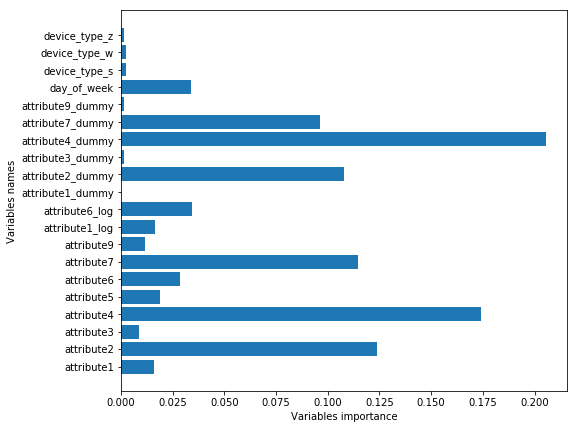

In [27]:
# 2) Variable selection using the feature importance from Random Forest
# At this step Random Forest is used only as a feature selection method. I'll obtain the feature importance from RF
# At a later stage, I'll also use Random Forest as a classification model
vs_model_rf = RandomForestClassifier(n_estimators = 500,        # From prior experience I've noticed that a few hundred trees are usually enough for small datasets
                                     random_state = 0,
                                     max_depth = 3,             # We don't have much observations, so that's why I set max tree depth to 2
                                     class_weight = "balanced") # parameter to adjust for the imbalanced dataset
vs_model_rf.fit(x_train, y_train)

# Plot the feature importance values
def plotFeatureImportance(model):
    plt.figure(figsize = (8, 7))
    num_features = len(list(x_train.columns))
    plt.barh(range(num_features), model.feature_importances_)
    plt.yticks(np.arange(num_features), list(x_train.columns))
    plt.xlabel("Variables importance")
    plt.ylabel("Variables names")
    
plotFeatureImportance(vs_model_rf)

Based on the variable importance plot, I'll drop certain features, and will re-run the Random Forest selection.

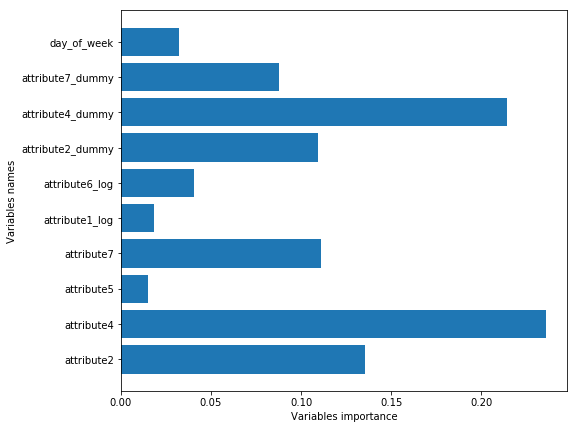

In [28]:
drop_col = ["attribute1", "attribute3", "attribute9", "attribute6",
            "attribute1_dummy", "attribute3_dummy", "attribute9_dummy",
            "device_type_s", "device_type_w", "device_type_z"]

x_train = x_train.drop(drop_col, axis = 1)
vs_model_rf = RandomForestClassifier(n_estimators = 500,        # From prior experience I've noticed that a few hundred trees are usually enough for small datasets
                                     random_state = 0,
                                     max_depth = 3,             # We don't have much observations, so that's why I set max tree depth to 2
                                     class_weight = "balanced") # parameter to adjust for the imbalanced dataset
vs_model_rf.fit(x_train, y_train)

# Plot the feature importance values
def plotFeatureImportance(model):
    plt.figure(figsize = (8, 7))
    num_features = len(list(x_train.columns))
    plt.barh(range(num_features), model.feature_importances_)
    plt.yticks(np.arange(num_features), list(x_train.columns))
    plt.xlabel("Variables importance")
    plt.ylabel("Variables names")
    
plotFeatureImportance(vs_model_rf)

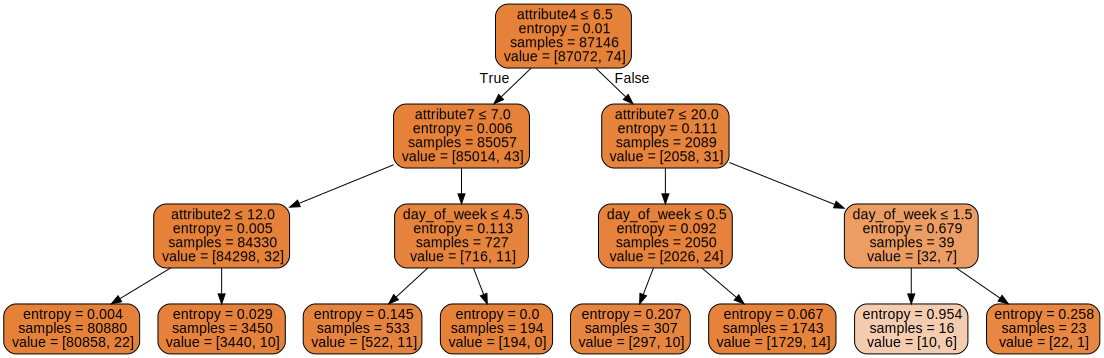

In [29]:
# 3) Finally, I'll build a decision tree to understand if there are any features from which we need to create categories
# Specify the decision tree model and fit
vs_model_dt = DecisionTreeClassifier(criterion = "entropy",
                                     random_state = 99,
                                     max_depth = 3,
                                     min_samples_split = 20)
vs_model_dt.fit(x_train, y_train)

# Visualize the decision tree
# Export the data from the decision tree as a DOT object
dt_viz = export_graphviz(vs_model_dt,
                         out_file = None,
                         feature_names = list(x_train),
                         filled = True, rounded = True,
                         special_characters = True)

# Plot the tree and explore which features split the tree
graphviz.Source(dt_viz)

Before continuing with the models, make sure that the features in the validation sample are the same as those in the training. If they are not the same, the model will error out.

In [30]:
x_validate = x_validate[list(x_train.columns)]

In [68]:
# 1) Logistic regression
# This is the easiest method for developing binary classification models
# We'll use the logistic regression as a benchmark for all other methods
lr_params = {"C": 1.0,
             "penalty": "l2",
             "class_weight": "balanced"}

model_lr = LogisticRegression(**lr_params)   # parameter to adjust for the imbalanced dataset. Weights are proportional to class frequencies.
model_lr.fit(x_train, y_train)


# Predict on training set and check the accuracy
modelAccuracyStats(model_lr, "Logistic regression", x_train, y_train, x_validate, y_validate)

Print stats for method: Logistic regression

The number of False Negative in the validation set is 5 
The number of False Positive in the validation set is 4281 

Accuracy on training set is 0.88649
Recall (tp/(tp+fn)) of training set is 0.77027

Accuracy on validation set is 0.88524
Recall (tp/(tp+fn)) of validation set is 0.84375


In [84]:
# 2) Random Forest classifier
# Define a random forest model and fit
rf_params = {"n_estimators": 700,
             "random_state": 0,
             "verbose": 0,
             "max_depth": 3,
             "class_weight": "balanced"}

model_rf = RandomForestClassifier(**rf_params) # parameter to adjust for the imbalanced dataset
model_rf.fit(x_train, y_train)

# Predict on training set and check the accuracy
modelAccuracyStats(model_rf, "Random Forest", x_train, y_train, x_validate, y_validate)

Print stats for method: Random Forest

The number of False Negative in the validation set is 6 
The number of False Positive in the validation set is 3468 

Accuracy on training set is 0.90679
Recall (tp/(tp+fn)) of training set is 0.77027

Accuracy on validation set is 0.90698
Recall (tp/(tp+fn)) of validation set is 0.81250


In [86]:
# 3) Gradient boosting with XGboost
xgb_params = {"max_depth": 3,
              "learning_rate": 0.05,
              "n_estimators": 1000,
              "objective": 'binary:logistic',
              "min_child_weight": 3,
              "max_depth": 6,
              "seed": 0,
              "subsample": 0.8,
              "colsample_bytree": 0.8}

model_xgb = xgb.XGBClassifier(**xgb_params)
model_xgb.fit(x_train, y_train,
              sample_weight = None) # This option can be used if I implement sampling to control the imbalanced dataset

# Predict on training set and check the accuracy
modelAccuracyStats(model_xgb, "XGBoost", x_train, y_train, x_validate, y_validate)

Print stats for method: XGBoost

The number of False Negative in the validation set is 31 
The number of False Positive in the validation set is 2 

Accuracy on training set is 0.99967
Recall (tp/(tp+fn)) of training set is 0.60811

Accuracy on validation set is 0.99912
Recall (tp/(tp+fn)) of validation set is 0.03125


In [88]:
# 4) Support vector machine
# SVM expects that all features have similar mean and stddev. Rescale the features before feeding the data to the model
# IMPORTANT - the rescaling needs to be done with the complete dataset, from which we'll pull training and validation samples


In [94]:
# Sampling
analysis_set_s = analysis_set[["failure", "attribute1_s", "attribute2_s", "attribute3_s", "attribute4_s", "attribute5_s", "attribute6_s",
                              "attribute7_s", "attribute9_s",
                              "attribute1_dummy", "attribute2_dummy", "attribute3_dummy",
                              "attribute4_dummy",
                              "attribute7_dummy",
                              "attribute9_dummy",
                              "day_of_week",
                              "device_type_s",
                              "device_type_w",
                              "device_type_z"]]

x_train_s, x_validate_s, y_train_s, y_validate_s = train_test_split(analysis_set_s.drop(["failure"], axis = 1),
                                                                    analysis_set_s["failure"],
                                                                    train_size = .7)

# Test if the % failure and non-failure remains the same in the new datasets as in the original dataset
print ("The rate of failures in the original set is " + str(Decimal(float(analysis_set["failure"].value_counts()[1])) / sum(analysis_set["failure"].value_counts())))
print ("The rate of failures in the training set is " + str(Decimal(float(y_train_s.value_counts()[1])) / sum(y_train_s.value_counts())))
print ("The rate of failures in the validation set is " + str(Decimal(float(y_validate_s.value_counts()[1])) / sum(y_validate_s.value_counts())))


The rate of failures in the original set is 0.0008514466560637460439860555529
The rate of failures in the training set is 0.0008606345745596419760169831889
The rate of failures in the validation set is 0.0008300088355779271198693405446


/Users/valentin/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
svm_params = {"C": 1.0,
              "degree": 3,
              "class_weight": "balanced",
              "probability": True}

model_svm = svm.SVC(**svm_params)

model_svm.fit(x_train_s, y_train_s,
              sample_weight = None)

modelAccuracyStats(model_svm, "SVM", x_train_s, y_train_s, x_validate_s, y_validate_s)

In [40]:
# 5) XGboost with cross-validation
cv_params = {'max_depth': [6], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.05,
              'n_estimators': 500,
              'seed':0,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'objective': 'binary:logistic'}

model_xgb_cv = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = 2)

model_xgb_cv.fit(x_train, y_train)


model_xgb_cv.grid_scores_

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'max_depth': [6], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [55]:
xgdmat = xgb.DMatrix(x_train, y_train)

our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 1000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

cv_xgb.tail(10)

In [57]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_xgb_cv = xgb.train(our_params, xgdmat, num_boost_round = 71)

In [71]:
y_pred = final_xgb_cv.predict(xgb.DMatrix(x_validate)) # Predict using our testdmat
roc_xgb_cv = roc_auc_score(y_validate, y_pred)
fpr_xgb_cv, tpr_xgb_cv, thresholds_xgb_cv = roc_curve(y_validate, y_pred)

#### Models evaluation
The models evaluation is done using the Receiver Operating Characteristics (ROC) curve

In [72]:
# 1) Use the ROC curve to evaluate accuracy of each model
# Obtain the parameters needed for each ROC curve for each model
y_pred_lr = model_lr.predict_proba(x_validate)[::,1]
roc_lr = roc_auc_score(y_validate, y_pred_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_validate, y_pred_lr)

y_pred_rf = model_rf.predict_proba(x_validate)[::,1]
roc_rf = roc_auc_score(y_validate, y_pred_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validate, y_pred_rf)

y_pred_xgb = model_xgb.predict_proba(x_validate_s)[::,1]
roc_xgb = roc_auc_score(y_validate_s, y_pred_xgb)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_validate_s, y_pred_xgb)

#y_pred_svm = model_svm.predict_proba(x_validate_s)[::,1]
#roc_svm = roc_auc_score(y_validate_s, y_pred_svm)
#fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_validate_s, y_pred_svm)

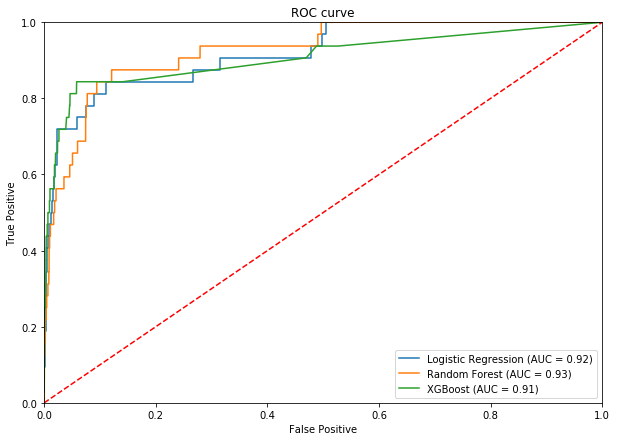

In [73]:
# Plot the ROC curve
plt.figure(figsize = (10, 7))
plt.plot(fpr_lr, tpr_lr, label = "Logistic Regression (AUC = %0.2f)" % roc_lr)
plt.plot(fpr_rf, tpr_rf, label = "Random Forest (AUC = %0.2f)" % roc_rf)
plt.plot(fpr_xgb, tpr_xgb, label = "XGBoost (AUC = %0.2f)" % roc_xgb)
#plt.plot(fpr_svm, tpr_svm, label = "SVM (AUC = %0.2f)" % roc_svm)

plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC curve")
plt.legend(loc = "lower right")


In [ ]:
# 2) Create a table that prints out the confusion matrices for each model
from sklearn.metrics import confusion_matrix

cm_df = np.stack((confusionMatrix(model_lr, x_validate, y_validate),
                  confusionMatrix(model_rf, x_validate, y_validate),
                  confusionMatrix(model_xgb, x_validate_s, y_validate_s),
                  confusionMatrix(model_svm, x_validate_s, y_validate_s)))

cm_df = pd.DataFrame(cm_df,
                     index = ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
                     columns = ["True Negative", "False Positive", "False Negative", "True Positive"])
cm_df

In [ ]:
training_features, test_features, \
training_target, test_target, = train_test_split(loans_relevant_enconded.drop(['bad_loans'], axis=1),
                                               loans_relevant_enconded['bad_loans'],
                                               test_size = .1,
                                               random_state=12)

x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)
                                                 
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

In [ ]:
# Check what values the model predicts
pred_train_model_rf = model_rf.predict(x_train)
pred_validate_model_rf = model_rf.predict(x_validate)

print(np.unique(pred_train_model_rf))
print(np.unique(pred_validate_model_rf))


In [ ]:
# THIS IS NOT A PROPER SAMPLING!!!
# IF TIME PERMITS IMPLEMENT THE SAMPLING PROCESS I STARTED BELOW

# For now just re-run this sampling until I get training and validation sets with failure rates similar to the original data

x_train, x_validate, y_train, y_validate = train_test_split(analysis_set.drop(["failure"], axis = 1),
                                                            analysis_set["failure"],
                                                            train_size = .7)

# Test if the % failure and non-failure remains the same in the new datasets as in the original dataset
print ("The rate of failures in the original set is " + str(Decimal(float(analysis_set["failure"].value_counts()[1])) / sum(analysis_set["failure"].value_counts())))
print ("The rate of failures in the training set is " + str(Decimal(float(y_train.value_counts()[1])) / sum(y_train.value_counts())))
print ("The rate of failures in the validation set is " + str(Decimal(float(y_validate.value_counts()[1])) / sum(y_validate.value_counts())))

#The rate of failures in the original set is 0.0008514466560637460439860555529
#The rate of failures in the training set is 0.001071007818357074006640248474
#The rate of failures in the validation set is 0.0007573497349275927753425286301

In [ ]:
# Sampling
x_train_s, x_validate_s, y_train_s, y_validate_s = train_test_split(analysis_set,
                                                                    analysis_set["failure"],
                                                                    train_size = .7)

# Test if the % failure and non-failure remains the same in the new datasets as in the original dataset
print ("The rate of failures in the original set is " + str(Decimal(float(analysis_set["failure"].value_counts()[1])) / sum(analysis_set["failure"].value_counts())))
print ("The rate of failures in the training set is " + str(Decimal(float(y_train_s.value_counts()[1])) / sum(y_train_s.value_counts())))
print ("The rate of failures in the validation set is " + str(Decimal(float(y_validate_s.value_counts()[1])) / sum(y_validate_s.value_counts())))


In [ ]:
# Oversampling
360*y_train.value_counts()[1] / float(sum(y_train.value_counts()))

x_train_m = x_train.sample(n = 360*y_train.value_counts()[1],
                           replace = True,
                           weights = None,
                           random_state = 0)